# read and operate data

In [55]:
import os
import pandas as pd

s = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz'
print('URL:', s)

column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

data = pd.read_csv(s,compression='gzip',header=None,names=column_names,encoding='utf-8')

attack_data = data[data['label'] != 'normal.']



URL: http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz


# encode features and map Probe vs. Not Probe classes to [1,-1]

In [62]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

X = attack_data.drop('label', axis=1)

y = attack_data['label']

#encode X
categorical_features = ['protocol_type', 'service', 'flag']
encoder = OneHotEncoder(handle_unknown='ignore')

X_categorical = encoder.fit_transform(X[categorical_features])
X_categorical = X_categorical.toarray()

categorical_feature_names = encoder.get_feature_names_out(categorical_features)
X_categorical_df = pd.DataFrame(X_categorical, columns=categorical_feature_names)

X = X.drop(categorical_features, axis=1)

X = X.reset_index(drop=True)
X_categorical_df = X_categorical_df.reset_index(drop=True)

X_encoded = pd.concat([X, X_categorical_df], axis=1)

#operate y
target_attacks = ['ipsweep.', 'nmap.', 'portsweep.', 'satan.']
y_binary = y.apply(lambda x: 1 if x in target_attacks else -1)


# under sample the majority class

In [53]:
from sklearn.utils import resample

print(y_binary.value_counts())

X_encoded = X_encoded.reset_index(drop=True)
y_binary = y_binary.reset_index(drop=True)

df_majority = X_encoded[y_binary == -1]
df_minority = X_encoded[y_binary == 1]


df_majority_downsampled = resample(df_majority,replace=False,n_samples=len(df_minority),random_state=42)

X_balanced = pd.concat([df_majority_downsampled, df_minority])
y_balanced = pd.concat([y_binary[df_majority_downsampled.index], y_binary[df_minority.index]])

print(y_balanced.value_counts())

label
-1    392636
 1      4107
Name: count, dtype: int64
label
-1    4107
 1    4107
Name: count, dtype: int64


# split data into train and test sets

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
print(f"train: {X_train.shape}, test: {X_test.shape}")

train: (6571, 114), test: (1643, 114)


# train Logistic Regression models

In [81]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=5000, random_state=42)

model.fit(X_train, y_train)

LogisticRegression(max_iter=5000, random_state=42)

# Test the model

In [82]:
train_accuracy = model.score(X_train, y_train)
print(f"train_accuracy: {train_accuracy:.4f}")

test_accuracy = model.score(X_test, y_test)
print(f"test_accuracy: {test_accuracy:.4f}")

iterations = model.n_iter_[0]
print(f"iterations: {iterations}")

train_accuracy: 0.9988
test_accuracy: 0.9988
iterations: 2626


It's not overfit beacuse the test_accuracy is same as train_accuracy, and the test_accuracy is very high.

It took 2626 iteration to converge.

In [70]:
coefficients = model.coef_[0]

feature_names = X_balanced.columns

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)\

print(coef_df.head())

                        Feature  Coefficient  Abs_Coefficient
31       dst_host_diff_srv_rate     5.144162         5.144162
26                diff_srv_rate     4.645831         4.645831
32  dst_host_same_src_port_rate     2.961046         2.961046
4                wrong_fragment    -2.493849         2.493849
34         dst_host_serror_rate    -2.067028         2.067028


dst_host_diff_srv_rate and diff_srv_rate have the largest weights in absolute value, they stand for the rate of different serves and they are related to Probe attacks. It is reasonable.

# compare between L1 and L2

In [84]:
from sklearn.linear_model import LogisticRegression

model_L1 = LogisticRegression(penalty='l1', solver='liblinear',max_iter=1000, random_state=42)

model_L1.fit(X_train, y_train)

model_L2 = LogisticRegression(penalty='l2', solver='liblinear',max_iter=1000, random_state=42)
model_L2.fit(X_train, y_train)

train_accuracy = model_L1.score(X_train, y_train)
print(f"train_accuracy_model_L1: {train_accuracy:.4f}")

test_accuracy = model_L1.score(X_test, y_test)
print(f"test_accuracy_model_L1: {test_accuracy:.4f}")
print()

train_accuracy = model_L2.score(X_train, y_train)
print(f"train_accuracy_model_L2: {train_accuracy:.4f}")

test_accuracy = model_L2.score(X_test, y_test)
print(f"test_accuracy_model_L2: {test_accuracy:.4f}")

train_accuracy_model_L1: 0.9994
test_accuracy_model_L1: 1.0000

train_accuracy_model_L2: 0.8577
test_accuracy_model_L2: 0.8491


L1 has higher accuracy

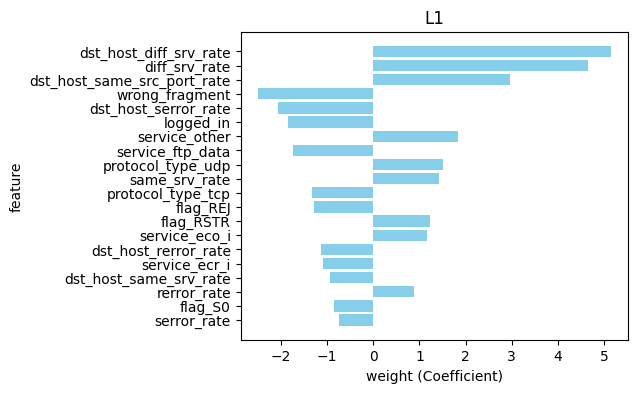

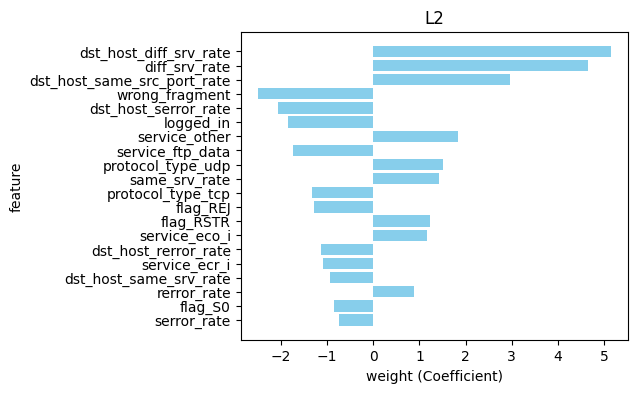

In [95]:
import matplotlib.pyplot as plt

coefficients = model_L1.coef_[0]

feature_names = X_balanced.columns

coef_df_L1 = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

coef_df_L1['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df_L1 = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
coef_df_L1 = coef_df_L1.head(20)

plt.figure(figsize=(5, 4))

plt.barh(coef_df_L1['Feature'], coef_df_L1['Coefficient'], color='skyblue')

plt.title('L1')
plt.xlabel('weight (Coefficient)')
plt.ylabel('feature')

plt.gca().invert_yaxis()

plt.show()

coef_df_L2 = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

coef_df_L2['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df_L2 = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
coef_df_L2 = coef_df_L1.head(20)

plt.figure(figsize=(5, 4))

plt.barh(coef_df_L2['Feature'], coef_df_L2['Coefficient'], color='skyblue')

plt.title('L2')
plt.xlabel('weight (Coefficient)')
plt.ylabel('feature')

plt.gca().invert_yaxis()

plt.show()

 feature weights are similar

# different strengths for L2 regularization

In [104]:
C_values = [0.01, 0.1, 1, 10, 100]

for C in C_values:
  model_L2 = LogisticRegression(penalty='l2',C=C,solver='lbfgs',max_iter=5000, random_state=42)
  model_L2.fit(X_train, y_train)

  print(f"regularization strength: {1/C}")

  train_accuracy = model_L2.score(X_train, y_train)
  print(f"train_accuracy_model_L2: {train_accuracy:.4f}")

  test_accuracy = model_L2.score(X_test, y_test)
  print(f"test_accuracy_model_L2: {test_accuracy:.4f}")
  print()

regularization strength: 100.0
train_accuracy_model_L2: 0.9833
test_accuracy_model_L2: 0.9811

regularization strength: 10.0
train_accuracy_model_L2: 0.9976
test_accuracy_model_L2: 0.9957

regularization strength: 1.0
train_accuracy_model_L2: 0.9988
test_accuracy_model_L2: 0.9988

regularization strength: 0.1
train_accuracy_model_L2: 0.9997
test_accuracy_model_L2: 0.9988

regularization strength: 0.01
train_accuracy_model_L2: 1.0000
test_accuracy_model_L2: 0.9988



train and test accuracy are higher when regularization strength goes lower. It's normal because higher regularization strength prevents the overfit.